In [1]:
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## Organize training data

In [2]:
Train_file_PAT =r'.//train_dataset//REG_dataset_XY.tsv'
# read tsv
train_ds = pd.read_csv(Train_file_PAT, sep='\t', na_values=['.'], header=0)
train_ds = train_ds.drop(train_ds.columns[range(4)],axis=1)
train_ds = train_ds.fillna(train_ds.mean())

# pandas.DataFrame -->numpy
train_np = train_ds.values
x_train = train_np[:, :-1]
y_train = train_np[:, -1]

## Organize testing data

In [3]:
test_dataset_filename = ['Brown_eQTL','GTEx_eQTL', ] #19维特征
x_test = {}
y_test = {}
    
for test_index, test_file_name in enumerate(test_dataset_filename,start=0):
    test_file =  r'.//test_dataset//' + test_file_name +'_dataset_XY.tsv'    
    test_ds = pd.read_csv(test_file, sep='\t', na_values=['.'], header=0)
    
    if(test_ds.shape[1] == 19):
        test_ds = test_ds.fillna(test_ds.mean())
        test_ds = test_ds.drop(test_ds.columns[range(4)], axis=1)
    elif(test_ds.shape[1] == 30):
        test_ds = test_ds.fillna(test_ds.mean())
        test_ds = test_ds.drop(test_ds.columns[range(9)], axis=1)
        test_ds = test_ds.drop(test_ds.columns[14:20], axis=1)


    test_np = test_ds.values
    x_test[test_index] = test_np[:, :-1]
    y_test[test_index] = test_np[:, -1]
   

c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Model building

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import StratifiedKFold,GridSearchCV

#### Building Stacking

In [5]:
from sklearn import metrics
REG = {"colsample_bylevel":0.6,"colsample_bytree":1.0,"gamma":5.0,"learning_rate":0.1,
 "max_depth":4,"min_child_weight":4.0,"n_estimators":300,"reg_alpha":5.0,"reg_lambda":0.01,
 "scale_pos_weight":10.6580903373,"subsample":1}

estimators = [     
        ('GBDT',GBDT(criterion='friedman_mse', learning_rate=0.17, loss='exponential', min_samples_split=7, n_estimators=130)),
        ('KNN',KNN(n_neighbors=95,p=1,weights='distance')),
        ('LR',LR(C=60,penalty='l2', solver='lbfgs',max_iter=300)),
        ('regBase', XGBClassifier( **REG)),
        ('RF', RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=40, min_samples_split=82, n_estimators=490)),
        ('SVM', SVC(C=13,gamma=4,probability=True))
]
stacking_EXT = ExtraTreesClassifier(criterion='gini',max_depth=80,min_samples_leaf=4,min_samples_split=17,n_estimators=150)
REG_Stacking = StackingClassifier(estimators=estimators, final_estimator = stacking_EXT,stack_method='predict_proba',n_jobs=12,passthrough=True)





#### Building Basemodels

In [6]:
from sklearn.model_selection import StratifiedKFold

REG = {"colsample_bylevel":0.6,"colsample_bytree":1.0,"gamma":5.0,"learning_rate":0.1,
 "max_depth":4,"min_child_weight":4.0,"n_estimators":300,"reg_alpha":5.0,"reg_lambda":0.01,
 "scale_pos_weight":10.6580903373,"subsample":1}

skfFoldtime = 5
skf = StratifiedKFold(n_splits= skfFoldtime,shuffle=True,random_state=10)

REG_GBDT = GBDT(criterion='friedman_mse', learning_rate=0.17, loss='exponential', min_samples_split=7, n_estimators=23)
REG_KNN = KNN(n_neighbors=12,p=1,weights='distance')
REG_LR = LR(C=60,penalty='l2', solver='lbfgs',max_iter=300)
REG_XGBoost = XGBClassifier( **REG)
REG_RF = RandomForestClassifier( criterion = 'entropy', max_depth=40, min_samples_split=82, n_estimators=13)
REG_SVM = SVC(C=21,gamma=0.05,probability=True)





In [7]:
REG_model_List = [REG_GBDT, REG_KNN, REG_LR, REG_XGBoost,REG_SVM, REG_RF, REG_Stacking]

### All models fitting

In [8]:
## Get the instance name
import inspect
def retrieve_name(var):
    '''
    utils:
    get back the name of variables
    '''
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

#### All models fitting

In [9]:
for index_classifier, (classifier) in enumerate(REG_model_List,start=0):
    print(retrieve_name(classifier)[0],'is fitting =======================')
    classifier.fit(x_train, y_train)

    

REG_GBDT is fitting =======================
REG_KNN is fitting =======================
REG_LR is fitting =======================
REG_XGBoost is fitting =======================
REG_SVM is fitting =======================
REG_RF is fitting =======================
REG_Stacking is fitting =======================


### model_save

In [10]:
import joblib
for fitted_classifier in REG_model_List:
    filename = ".//model//REG//" + retrieve_name(fitted_classifier)[0] + ".model"
    joblib.dump(fitted_classifier, filename = filename)

In [50]:
from sklearn.metrics import roc_curve,roc_auc_score,auc

def multi_models_roc(names, sampling_methods, colors, X_test, y_test, save_name, save=True, dpin=100):
        """
        Output the AUROC results obtained by all models to a graph
        
        Args:
            names: list, model names
            sampling_methods: list, instantiated objects for all models
            save: Choose whether to save the result (default is png format)
            
        Returns:
            Returns the image object plt
        """
        plt.figure(figsize=(5, 5), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            y_test_preds = method.predict(X_test)
            y_test_predprob = method.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)
            
            plt.plot(fpr, tpr, lw=2, label='{} (AUC={:.4f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=2, color = 'grey')
            plt.axis('square')  
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=13)
            plt.ylabel('True Positive Rate',fontsize=13)
            plt.title('GTEx_eQTL',fontsize=20)
            plt.legend(loc='lower right',fontsize=11)

        if save:
            plt.savefig('REG_auroc'+save_name+'_baseClf.png')
            
        return plt



In [51]:
from sklearn.metrics import roc_curve,roc_auc_score,auc

def multi_models_auprc(names, sampling_methods, colors, X_test, y_test,  save_name, save=True, dpin=100):
        """
        Output the Auprc results obtained by all models to a graph
        
        Args:
            names: list, model names
            sampling_methods: list, instantiated objects for all models
            save: Choose whether to save the result (default is png format)
            
        Returns:
            Returns the image object plt
        """
            
            
        plt.figure(figsize=(5, 5), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            y_test_predprob = method.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)
            precision, recall,_ = precision_recall_curve(y_test, y_test_predprob)
            
            plt.plot(recall, precision, lw=2, label='{} (AUC={:.4f})'.format(name, auc(recall, precision)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=2, color = 'grey')
            plt.axis('square')  
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('Recall',fontsize=13)
            plt.ylabel('Precision',fontsize=13)
            plt.title('GTEx_eQTL',fontsize=20)
            plt.legend(loc='lower right',fontsize=11)

        if save:
            plt.savefig('REG_multi_models_aupr'+save_name+'_baseClf.png')
            
        return plt



#### get predictions

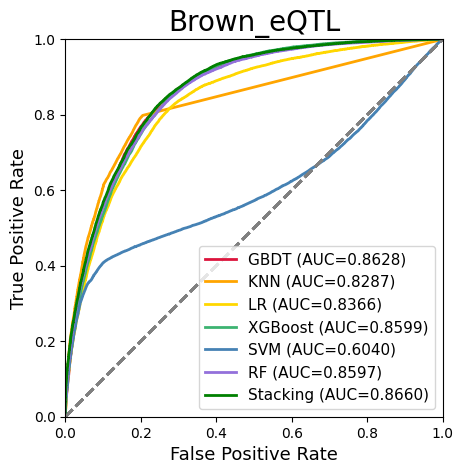

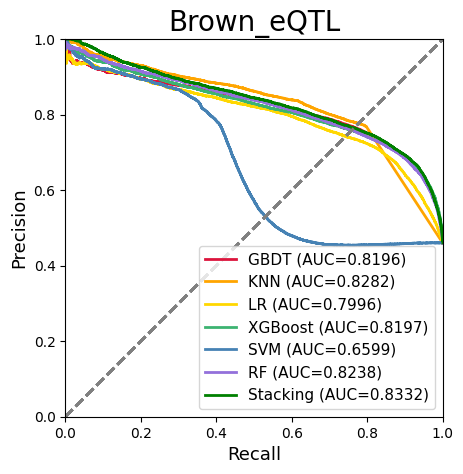

In [49]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
names = ['GBDT', 'KNN', 'LR', 'XGBoost', 'SVM','RF','Stacking']

colors = ['crimson',
          'orange',
          'gold',
          'mediumseagreen',
          'steelblue', 
          'mediumpurple',
          'green',
          'black'
]

REG_ROC_graph = multi_models_roc(names, REG_model_List, colors,x_test[0],y_test[0],save_name="base_model_Brown_eQTL")
REG_AUPRC_graph = multi_models_auprc(names, REG_model_List, colors,x_test[0],y_test[0],save_name="base_model_Brown_eQTL")

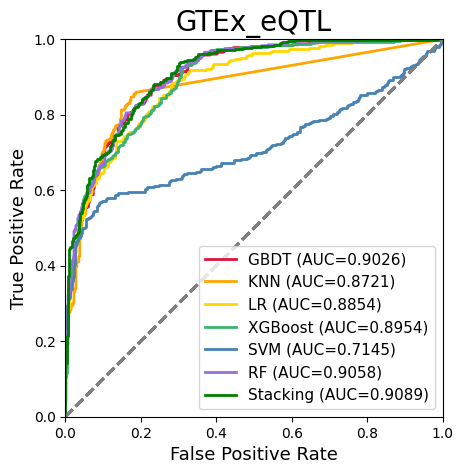

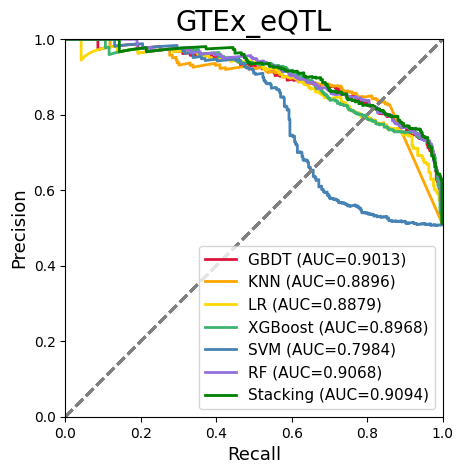

In [52]:
REG_ROC_graph = multi_models_roc(names, REG_model_List, colors,x_test[1],y_test[1],save_name="base_model_GTEx_eQTL")
REG_AUPRC_graph = multi_models_auprc(names, REG_model_List, colors,x_test[1],y_test[1],save_name="base_model_GTEx_eQTL")

## Other_method

In [14]:
test_dataset_filename = ['Brown_eQTL','GTEx_eQTL',] #19维特征
x_test = {}
y_test = {}
test_ds = {}

    
for test_index, test_file_name in enumerate(test_dataset_filename,start=0):
    test_file =  r'.//test_dataset//' + test_file_name +'_dataset_XY.tsv'    
    test_ds[test_index]= pd.read_csv(test_file, sep='\t', na_values=['.'], header=0)
    
    if(test_ds[test_index].shape[1] == 19):
        test_ds[test_index] = test_ds[test_index].fillna(test_ds[test_index].mean())
        test_ds[test_index] = test_ds[test_index].drop(test_ds[test_index].columns[range(4)], axis=1)
    elif(test_ds[test_index].shape[1] == 30):
        test_ds[test_index] = test_ds[test_index].fillna(test_ds[test_index].mean())
        test_ds[test_index] = test_ds[test_index].drop(test_ds[test_index].columns[range(9)], axis=1)
        test_ds[test_index] = test_ds[test_index].drop(test_ds[test_index].columns[14:20], axis=1)
    test_np = test_ds[test_index].values
    x_test[test_index] = test_np[:, :-1]
    y_test[test_index] = test_np[:, -1]
    print(x_test[test_index].shape)

c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(67635, 14)
(796, 14)


## CADD,CScape,DANN,FATHMM-MKL,FIRE

In [16]:
colors = ['crimson',
          'orange',
          'gold',
          'mediumseagreen',
          'steelblue',
]

method_list = ['CADD','CScape','DANN','FATHMM-MKL','FIRE']
method_data = {}
method_data[0] = np.concatenate((test_ds[0]['CADD'].values.reshape(-1,1), test_ds[0]['CScape'].values.reshape(-1,1),
                            test_ds[0]['DANN'].values.reshape(-1,1),test_ds[0]['FATHMM-MKL'].values.reshape(-1,1),
                            test_ds[0]['FIRE'].values.reshape(-1,1)),axis=1)

method_data[1] = np.concatenate((test_ds[1]['CADD'].values.reshape(-1,1), test_ds[1]['CScape'].values.reshape(-1,1),
                            test_ds[1]['DANN'].values.reshape(-1,1),test_ds[1]['FATHMM-MKL'].values.reshape(-1,1),
                            test_ds[1]['FIRE'].values.reshape(-1,1)),axis=1)



label = train_ds['label']

print(method_data[0].shape)
print(method_data[1].shape)

(67635, 5)
(796, 5)


### DeepGS

In [17]:

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

# model_build
inp = Input(shape=(14,1))
x = Conv1D(14,10,activation='relu')(inp)
x = MaxPooling1D(pool_size=4,strides=4)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(2, activation='sigmoid')(x)
out = Dropout(0.05)(x)

model_DeepGS = Model(inputs=inp, outputs=out)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=False)
model_DeepGS.compile(optimizer='sgd',
              loss='mean_absolute_error',
              metrics=['mae'])

# model.fit
y_one_hot = to_categorical(y_train, num_classes=None)
model_DeepGS.fit(x_train.reshape((-1,14,1)), y_one_hot, batch_size=256, 
              validation_split=0.1,epochs=100 )

y_test_predprob_DeepGS = {}
method_list.append('DeepGS')
for test_index, test_file_name in enumerate(test_dataset_filename,start=0):
    print(test_index)
    y_test_predprob_DeepGS[test_index] = model_DeepGS.predict(x_test[test_index])[:,1]
    print(y_test_predprob_DeepGS[test_index].shape)
    method_data[test_index] = np.append(method_data[test_index],y_test_predprob_DeepGS[test_index].reshape(-1,1),axis = 1)

Epoch 1/100
216/216 [==============================] - 1s 2ms/step - loss: 0.4949 - mae: 0.4949 - val_loss: 0.4157 - val_mae: 0.4157
Epoch 2/100
216/216 [==============================] - 0s 1ms/step - loss: 0.4120 - mae: 0.4120 - val_loss: 0.3123 - val_mae: 0.3123
Epoch 3/100
216/216 [==============================] - 0s 1ms/step - loss: 0.3260 - mae: 0.3260 - val_loss: 0.1965 - val_mae: 0.1965
Epoch 4/100
216/216 [==============================] - 0s 1ms/step - loss: 0.2395 - mae: 0.2395 - val_loss: 0.1068 - val_mae: 0.1068
Epoch 5/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1750 - mae: 0.1750 - val_loss: 0.0626 - val_mae: 0.0626
Epoch 6/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1534 - mae: 0.1534 - val_loss: 0.0464 - val_mae: 0.0464
Epoch 7/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1432 - mae: 0.1432 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 8/100
216/216 [==============================] - 0s 1ms/step - 

In [18]:
print(method_data[0].shape)
print(method_data[1].shape)

(67635, 6)
(796, 6)


### regBase

In [19]:
from xgboost import XGBClassifier
REG = {"colsample_bylevel":0.6,"colsample_bytree":1.0,"gamma":5.0,"learning_rate":0.1,
 "max_depth":4,"min_child_weight":4.0,"n_estimators":300,"reg_alpha":5.0,"reg_lambda":0.01,
 "scale_pos_weight":10.6580903373,"subsample":1}


model_regBase = XGBClassifier(n_jobs=2, **REG)

model_regBase.fit(x_train, y_train)

y_test_predprob_regBase = {}
method_list.append('regBase')
for test_index, test_file_name in enumerate(test_dataset_filename,start=0):
    print(test_index)
    y_test_predprob_regBase[test_index] = model_regBase.predict_proba(x_test[test_index])[:,1]
    print(y_test_predprob_regBase[test_index].shape)
    print(y_test_predprob_regBase[test_index].shape)
    method_data[test_index] = np.append(method_data[test_index],y_test_predprob_regBase[test_index].reshape(-1,1),axis = 1)

0
(67635,)
(67635,)
1
(796,)
(796,)


## Stacking

In [20]:
method_list.append('Stacking')
for test_index, test_file_name in enumerate(test_dataset_filename,start=0):
    print(test_index)
    y_test_predprob_regBase[test_index] = REG_Stacking.predict_proba(x_test[test_index])[:,1]
    print(y_test_predprob_regBase[test_index].shape)
    method_data[test_index] = np.append(method_data[test_index],y_test_predprob_regBase[test_index].reshape(-1,1),axis = 1)

0
(67635,)
1
(796,)


In [21]:
print(method_list)
print(method_data[0].shape)
print(method_data[1].shape)

['CADD', 'CScape', 'DANN', 'FATHMM-MKL', 'FIRE', 'DeepGS', 'regBase', 'Stacking']
(67635, 8)
(796, 8)


In [31]:
from sklearn.metrics import roc_curve,roc_auc_score,auc,precision_recall_curve
from sklearn import metrics

def multi_method_AUROC(names,  colors, X_test, y_test,save_name,save=True, dpin=100):
        """
        Output the AUROC results obtained by all models to a graph
        
        Args:
            names: list, methods names
            sampling_methods: list, instantiated objects for all methods
            save: Choose whether to save the result (default is png format)
            
        Returns:
            Returns the image object plt
        """
        plt.figure(figsize=(5, 5), dpi=dpin)

        for (method_index, method_name) in enumerate(names, start=0):
            y_test_predprob = X_test[:,method_index]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)
            print(method_name)
            
            plt.plot(fpr, tpr, lw=2, label='{} (AUC={:.4f})'.format(method_name, auc(fpr, tpr)),color = colors[method_index])
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')  
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=13)
            plt.ylabel('True Positive Rate',fontsize=13)
            #plt.title('ROC Curve',fontsize=8)
            plt.legend(loc='lower right',fontsize=8)

        if save:
            plt.savefig('REG_multi_models_auroc'+save_name+'_otherMethod.png')
            
        return plt

In [32]:
from sklearn.metrics import roc_curve,roc_auc_score,auc,precision_recall_curve
from sklearn import metrics

def multi_method_AUPRC(names,  colors, X_test, y_test,save_name,save=True, dpin=100):
        """
        Output the AUPRC results obtained by all models to a graph
        
        Args:
            names: list, methods names
            sampling_methods: list, instantiated objects for all methods
            save: Choose whether to save the result (default is png format)
            
        Returns:
            Returns the image object plt
        """
        plt.figure(figsize=(5, 5), dpi=dpin)

        for (method_index, method_name) in enumerate(names, start=0):
            y_test_predprob = X_test[:,method_index]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)
            print(method_name)
            
            precision, recall,_ = precision_recall_curve(y_test, y_test_predprob)
            plt.plot(recall, precision, lw=2, label='{} (AUC={:.4f})'.format(method_name, auc(recall, precision)),color = colors[method_index])
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')  
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=13)
            plt.ylabel('True Positive Rate',fontsize=13)
            #plt.title('AUPR Curve',fontsize=6)
            plt.legend(loc='lower right',fontsize=8)

        if save:
            plt.savefig('REG_multi_models_aupr_'+save_name+'otherMethod.png')
            
        return plt

CADD
CScape
DANN
FATHMM-MKL
FIRE
DeepGS
regBase
Stacking
CADD
CScape
DANN
FATHMM-MKL
FIRE
DeepGS
regBase
Stacking


<module 'matplotlib.pyplot' from 'c:\\program files\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

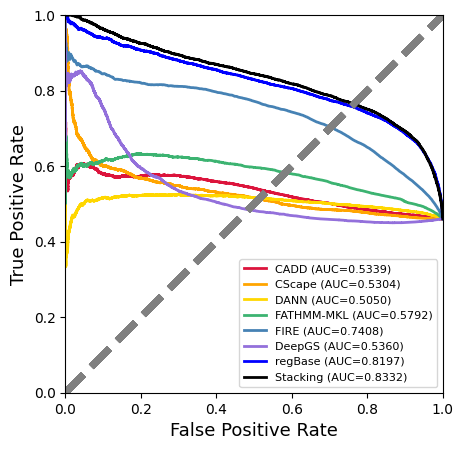

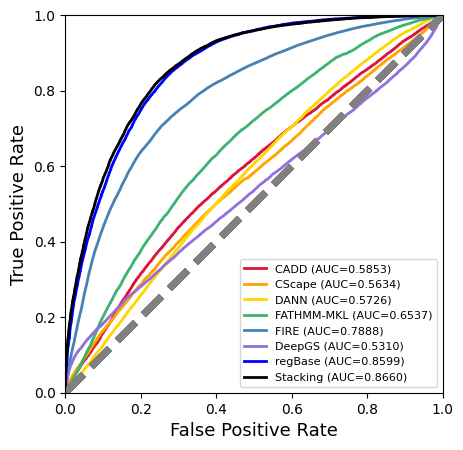

In [33]:
colors = ['crimson',
          'orange',
          'gold',
          'mediumseagreen',
          'steelblue', 
          'mediumpurple',
          'blue',
          'black'
]


multi_method_AUPRC(method_list, colors, method_data[0],y_test[0],'other_Brown')
multi_method_AUROC(method_list, colors, method_data[0],y_test[0],'other_Brown')


CADD
CScape
DANN
FATHMM-MKL
FIRE
DeepGS
regBase
Stacking
CADD
CScape
DANN
FATHMM-MKL
FIRE
DeepGS
regBase
Stacking


<module 'matplotlib.pyplot' from 'c:\\program files\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

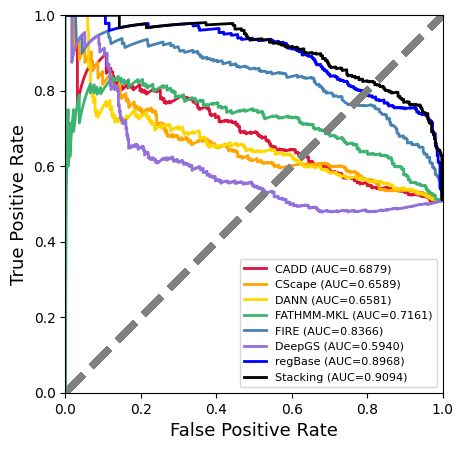

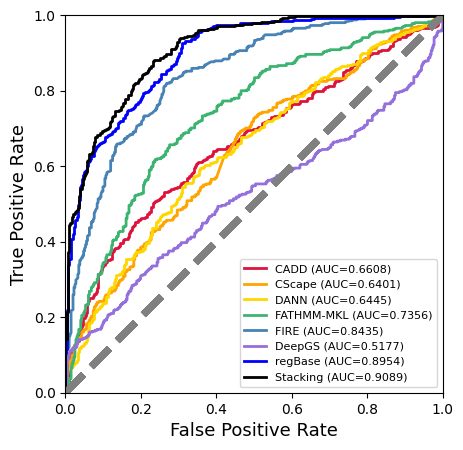

In [34]:
multi_method_AUPRC(method_list, colors, method_data[1],y_test[1],'GTEx')
multi_method_AUROC(method_list, colors, method_data[1],y_test[1],'GTEx')

In [ ]:
model_DeepGS.save('./model/REG/REG_DeepGS.h5')#这个方法将网络结构与权重一起保存到dnn.h5中
file_regBase = ".//model//REG//" + "REG_regBase" + ".model"

joblib.dump(model_regBase, filename = file_regBase)